# Задача

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

# **Импорт и общая информация датасета**

Описание полей  

- children — количество детей в семье  
- days_employed — общий трудовой стаж в днях  
- dob_years — возраст клиента в годах  
- education — уровень образования клиента  
- education_id — идентификатор уровня образования  
- family_status — семейное положение  
- family_status_id — идентификатор семейного положения  
- gender — пол клиента  
- income_type — тип занятости  
- debt — имел ли задолженность по возврату кредитов  
- total_income — ежемесячный доход  
- purpose — цель получения кредита

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pymystem3 import Mystem
m = Mystem()

from collections import Counter

import warnings
warnings.filterwarnings("ignore");

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


# **Предобработка данных**

## **Обработка пропусков**

In [5]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропущенные значения в датасете присутствуют в столбцах days_employed и total_income. Их количество одинаковое. Проверим соответствуют ли они

In [6]:
len(df[(df['days_employed'].isna()) & (df['total_income'].isna())])

2174

Да, пропущенные значения соответствуют

Правильнее будет заменить пропущенные значения исходя из типа занятости клиента. Но сначала проверим значения этих столбцов на аномалии

In [7]:
df['days_employed'].min(), df['days_employed'].max()

(-18388.949900568383, 401755.40047533)

В days_employed присутствуют отрицательные значения. Заменим их абсолютным значением

In [8]:
df['days_employed'] = df['days_employed'].map(lambda x: abs(x))

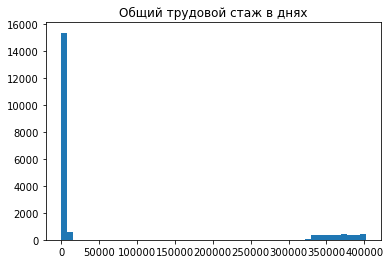

In [9]:
plt.hist(df['days_employed'], bins=50)
plt.title('Общий трудовой стаж в днях')
plt.show()

Также присутствуют аномальные значения. Если 52 (количество лет от 18 до 70) лет умножить на 365 дней, то получится 18980 дней. Значения большие от этого будем считать аномальными

In [10]:
df[df['days_employed']>18980]['days_employed'].count()

3445

Таких аномальных значений 3445. Наверное, они появились из-за того, что их считали по часам, а не по дням

In [11]:
print(400000 / 24)

16666.666666666668


Кажется правдоподобным. Тогда поделим аномальные значения на 24

In [12]:
df['days_employed'] = df['days_employed'].map(lambda x: x/24 if x > 18980 else x)

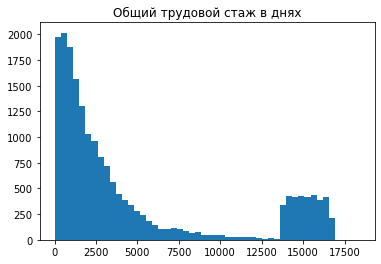

In [13]:
plt.hist(df['days_employed'], bins=50)
plt.title('Общий трудовой стаж в днях')
plt.show()

Интересное скопление значений в интервале 13750 - 17000. Выясним почему так получилось

In [14]:
df[df['days_employed']>13750]['income_type'].value_counts()

пенсионер      3384
сотрудник        18
госслужащий       7
компаньон         7
безработный       2
Name: income_type, dtype: int64

Оказывается, эти значения принадлежат пенсионерам. Все сходится - у них большой трудовой стаж, поэтому значения сильно отклоняются от среднего

Теперь посмотрим на столбец total_income

In [15]:
df['total_income'].min(), df['total_income'].max()

(20667.26379327158, 2265604.028722744)

Не присутствуют отрицательные значения

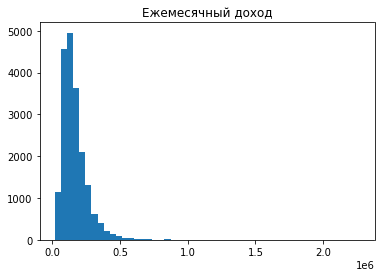

In [16]:
plt.hist(df['total_income'], bins=50)
plt.title('Eжемесячный доход')
plt.show()

Есть аномальные значения, которые слишком далеко отклоняются в большую сторону. Избавимся от них с помощью перцентилей

In [17]:
max_threshold = df['total_income'].quantile(0.99)
max_threshold

517206.827256117

In [18]:
df = df[(df['total_income'] < max_threshold) | (df['total_income'].isna())]

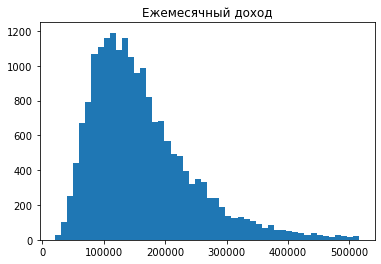

In [19]:
plt.hist(df['total_income'], bins=50)
plt.title('Eжемесячный доход')
plt.show()

Теперь распределение выглядит лучше!

In [20]:
def df_fillna_days_employed(row):
    income_type = row['income_type']
    median_days = df.groupby('income_type')['days_employed'].median()[income_type]
    return median_days

In [21]:
def df_fillna_total_income(row):
    income_type = row['income_type']
    median_income = df.groupby('income_type')['total_income'].median()[income_type]
    return median_income

In [22]:
df.loc[df['days_employed'].isna(), 'days_employed'] = df.loc[df['days_employed'].isna()].apply(df_fillna_days_employed, axis=1)

In [23]:
df.loc[df['total_income'].isna(), 'total_income'] = df.loc[df['total_income'].isna()].apply(df_fillna_total_income, axis=1)

In [24]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [25]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,14177.753002,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


С пропущенными значениями разобрались. Посмотрим на ошибочные значения

## Обработка ошибочных значений

In [26]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

Присутствует значение -1 в количестве детей клиентов

In [27]:
df['children'] = df['children'].map(lambda x: abs(x))

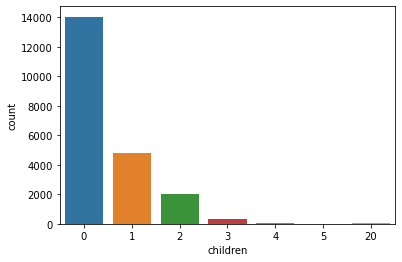

In [28]:
sns.countplot(df['children'])
plt.show()

In [29]:
len(df[df['children'] == 20])

76

Всего 76 клиентов с 20 детьми. Можно избавиться от них

In [30]:
df = df.loc[df['children']!=20]

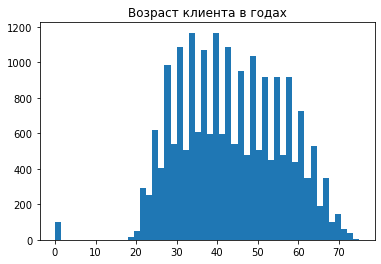

In [31]:
plt.hist(df['dob_years'], bins=50)
plt.title('Bозраст клиента в годах')
plt.show()

In [32]:
len(df[df['dob_years'] < 18])

100

В данных есть 100 клиентов младше 18 лет. Кредиты выдают лишь совершеннолетним клиентам. Заменим их на медианный возраст исходя от типа занятости

In [33]:
def df_anomaly_dob_years(row):
    income_type = row['income_type']
    median_year = df.groupby('income_type')['dob_years'].median()[income_type]
    return median_year

In [34]:
df.loc[df['dob_years'] < 18, 'dob_years'] = df.loc[df['dob_years'] < 18].apply(df_anomaly_dob_years, axis=1)

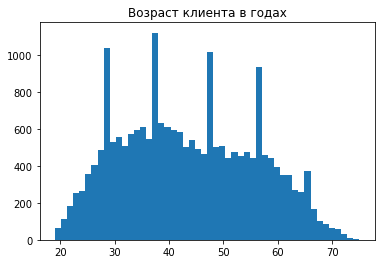

In [35]:
plt.hist(df['dob_years'], bins=50)
plt.title('Bозраст клиента в годах')
plt.show()

Теперь распределение выглядит лучше

In [36]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Значения в столбце education написаны разными регистрами. Приведем всех их в нижний регистр

In [37]:
df['education'].str.lower().unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Правильно, у нас всего 5 классов в этом столбце

In [38]:
df['education'] = df['education'].str.lower()

In [39]:
df['education_id'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [40]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [41]:
df['family_status_id'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [42]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [43]:
len(df[df['gender'] == 'XNA'])

1

Кто-то указал в поле 'XNA'. Он всего лишь один, поэтому избавимся от этого пришельца

In [44]:
df = df.loc[df['gender'] != 'XNA']

In [45]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [46]:
df['debt'].unique()

array([0, 1], dtype=int64)

In [47]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'сделка с подержанным автомобилем', 'получение образования',
       'заняться образованием', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

С пропусками разобрались!)

## **Замена типа данных**

In [48]:
df.dtypes

children              int64
days_employed       float64
dob_years           float64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

В столбцах days_employed, total_income и dob_years вещественный тип данных. Это может помешать нам для дальнейшего исследования. Заменим их на целочисленный с помощью метода astype()

In [49]:
df['days_employed'] = df['days_employed'].astype('int')

In [50]:
df['total_income'] = df['total_income'].astype('int')

In [51]:
df['dob_years'] = df['dob_years'].astype('int')

In [52]:
df.dtypes

children             int64
days_employed        int32
dob_years            int32
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int32
purpose             object
dtype: object

## **Обработка дубликатов**

In [53]:
df.duplicated().sum()

71

In [54]:
df = df.drop_duplicates().reset_index(drop=True)

In [55]:
df.duplicated().sum()

0

## Категоризация цели получения кредита

In [56]:
purposes = list(df['purpose'].unique())

In [57]:
purpose_text = ' '.join(purposes)

In [58]:
lemmas = m.lemmatize(purpose_text)

In [59]:
Counter(lemmas)

Counter({'покупка': 10,
         ' ': 96,
         'жилье': 7,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 2,
         'свой': 4,
         'со': 1,
         'сделка': 2,
         'получение': 3,
         'заниматься': 2,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1,
         '\n': 1})

Цели получения кредита соответствуют следующим категориям:  
1. Недвижимость
2. Автомобиль
3. Образование
4. Свадьба

In [60]:
def purpose_category(row):
    purpose = row['purpose']
    if ('недвижим' in purpose) or ('жиль' in purpose):
        return 'Недвижимость'
    elif 'автомоб' in purpose:
        return 'Автомобиль'
    elif 'образован' in purpose:
        return 'Образование'
    elif 'свадьб' in purpose:
        return 'Свадьба'
    return 'Неизвестно'

In [61]:
df['purpose_category'] = df.apply(purpose_category, axis=1)

In [62]:
df['purpose_category'].value_counts()

Недвижимость    10661
Автомобиль       4257
Образование      3967
Свадьба          2298
Name: purpose_category, dtype: int64

In [63]:
df = df.drop(['purpose'], axis=1)

In [64]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,Недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,Автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,Недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,Образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,Свадьба


Теперь все клиенты разбиты по категориям

# Проверка гипотез

## **Есть ли зависимость между наличием детей и возвратом кредита в срок?**

In [65]:
df[df['children']==0]['debt'].mean()

0.07549735222556175

In [66]:
df[df['children']>0]['debt'].mean()

0.09238451935081149

Видно, что клиенты без детей возвращают кредиты лучше

In [67]:
df.groupby('children').agg({'debt':['count', 'mean']})

debt          
          count      mean
children                 
0         13974  0.075497
1          4809  0.092119
2          2025  0.094815
3           325  0.083077
4            41  0.097561
5             9  0.000000

Да, видим резкое ухудшение среднего значения возврата кредитов. Следовательно, наличие детей отрицательно сказывается на кредитной репутации

## **Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [68]:
df.pivot_table(index='family_status', values='debt', aggfunc=['count', 'mean'])

,count,mean
,debt,debt
family_status,,
Не женат / не замужем,2780,0.097482
в разводе,1181,0.071126
вдовец / вдова,950,0.066316
гражданский брак,4108,0.092746
женат / замужем,12164,0.075797


Интересно, что женатые клиенты возвращают кредит лучше, чем клиенты с гражданским браком. В официальном браке (через ЗАГС) долги зачастую делятся поровну, а при сожительстве (гражданский брак) обязательства по их погашению ложатся исключительно на заемщика.

По таблице видно, что лучше всех возвращают кредит вдовы, хуже всех - не женатые клиенты и семьи с гражданским браком. Из-за различия в количестве клиентов в каждой группе, нельзя утверждать про явную зависимость.

## **Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [69]:
df.groupby('debt')['total_income'].mean()

debt
0    160381.417429
1    156570.249855
Name: total_income, dtype: float64

Средняя зарплата тех, кто возвращает кредиты вовремя кредиты выше

In [70]:
df['income_cut'] = pd.qcut(df['total_income'], 5)

In [71]:
df.groupby('income_cut')['debt'].mean()

income_cut
(20666.999, 98183.0]    0.080717
(98183.0, 131535.2]     0.082389
(131535.2, 160249.4]    0.089450
(160249.4, 211253.0]    0.082625
(211253.0, 516062.0]    0.071041
Name: debt, dtype: float64

Клиенты поровну разделены на 5 групп по размеру месячной зарплаты. Лучше всех возвращают кредит самые богатые клиенты. Но прямой зависимости между уровнем дохода и возвратом кредита в срок не наблюдается

## **Как разные цели кредита влияют на его возврат в срок?**

In [72]:
df.pivot_table(index='purpose_category', values='debt', aggfunc=['count', 'mean'])

,count,mean
,debt,debt
purpose_category,,
Автомобиль,4257,0.093728
Недвижимость,10661,0.072695
Образование,3967,0.092009
Свадьба,2298,0.079199


Люди лучше возвращают кредит, если берут его для покупки недвижимости. Затем идет кредит на свадьбу. И хуже возвращают кредит на автомобиль и образование с почти одинаковыми значениями.

## Как возвращают кредиты представители разных полов

In [73]:
df.pivot_table(index='gender', values='debt', aggfunc=['count', 'mean'])

,count,mean
,debt,debt
gender,,
F,14052,0.070168
M,7131,0.103071


Женщин в наших данных в два раза больше. По таблице видно, что они возвращают кредиты лучше, чем мужчины

## Есть ли зависимость между образованием и возвратом кредита в срок?

In [74]:
df.pivot_table(index='education', values='debt', aggfunc=['count', 'mean'])

,count,mean
,debt,debt
education,,
высшее,5108,0.053054
начальное,282,0.109929
неоконченное высшее,733,0.088677
среднее,15054,0.089943
ученая степень,6,0.000000


Люди с высшим образованием возвращают кредит намного лучше. Хуже всех оказались клиенты с начальным образованием. Интересный факт: из всего 6 клиентов с ученой степенью все погасили кредит вовремя)

Образование точно имеет зависимость на погашение кредита в срок

## Есть ли зависимость между возрастом клиента и возвратом кредита в срок?

In [75]:
df['dob_years_cut'] = pd.qcut(df['dob_years'], 5)

In [76]:
df.groupby('dob_years_cut')['debt'].mean()

dob_years_cut
(18.999, 32.0]    0.111416
(32.0, 39.0]      0.091558
(39.0, 47.0]      0.078390
(47.0, 56.0]      0.065516
(56.0, 75.0]      0.053850
Name: debt, dtype: float64

Видна прямая зависимость между возрастом клиента и возвратом кредита в срок. С возрастом клиенты возвращают кредиты вовремя

# Вывод

Мы провели предобработку и анализ данных кредитного отдела банка. Нашей целью было выявить: влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. И в результате исследования мы пришли к таким выводам:  
1. Клиенты берут кредит на одну из четырех категорий: недвижимость, автомобиль, образование и свадьба. Лучше всего возвращают кредит, если берут его для покупки недвижимости. Хуже всего - на автомобиль.  
2. Наличие детей отрицательно сказывается на возврат кредита вовремя  
3. Клиенты официально зарегистрировавшие свой брак возвращают кредит лучше, чем клиенты с гражданским браком  
4. Мы не нашли зависимости между уровнем дохода и возвратом кредита в срок  
5. Женщины возвращают кредит лучше, чем мужчины  
6. Есть прямая зависимость между образованием клиента и возвратом кредита в срок. Люди с высшим образованием возвращают кредит намного лучше.  
7. С возрастом клиенты возвращают кредиты вовремя